# Context
Data processing associated with Stefan's data collection done on [Aug 17, 2023](https://egnyte.nhgh.org/app/index.do#storage/files/1/Shared/Projects/Pediatric%20Pulse%20ROxi/alg%20development/Bench%20data%20for%20Nigeria%20study/Aug%2017%20reflective%20sensor%20placement), where the goal is to inspect the placement of the reflective biopac ppg sensor on the ppg waveform quality.

`timestamps.xlsx` is a manually annotated file with timestamp information corresponding to the data collection. "Start" and "End" times in `timestamps.xlsx` are in seconds. We need to manually convert them to datetime.


## Experiment Assumptions
Natural breathing is assumed (~14 breaths per minute for this adult male subject). RR algorithm evaluation uses seed as 20 breaths per minute to minimize the effect of the seed. Otherwise, setting the seed to 15 breaths per minute results in better than expected performance.

## Parameters
* Sensor placement

## Equipment Used
* Biopac

## Other notes


In [81]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from ppg2rr import signal_quality as sqi
from ppg2rr import util, riv_est
from ppg2rr.rr_est import estimate_rr_single_frame

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
exp_directory = '../data/bench/20230817 Reflective Sensor Placement/'

# Load Data & Time-Sync
biopac sensor only

In [84]:

# manual annotations with timings and parameters
timing_df = pd.read_excel(f'{exp_directory}/timestamps.xlsx')
timing_df = timing_df[['Run','Start','End','Note']]
timing_df['duration'] = timing_df['End']-timing_df['Start']

In [85]:
timing_df

,Run,Start,End,Note,duration
0,0,24,52,Below Deltoid,28
1,1,72,92,2 inches below wrist,20
2,2,130,146,Finger,16
3,3,164,180,Deltoid,16
4,4,205,218,1 inch below Wrist,13
5,5,244,262,Finger,18


## Biopac

In [86]:
biopac_file = 'reflective_sensor_3_placements_verbalize_times.txt'
df_biopac = pd.read_csv(f'{exp_directory}/{biopac_file}',header=None, skiprows=15)
fs_biopac = 2000
biopac_labels = ['time (min)','ppg', 'accelX', 'accelY', 'accelZ', 'n/a']
df_biopac.columns = biopac_labels
df_biopac.info()

# Convert minute column to datetime using the "Recording on" information in the .txt file.
biopac_time_start = pd.to_datetime('2023-08-17 16:24:23.333')
df_biopac['datetime'] = biopac_time_start + pd.to_timedelta(df_biopac['time (min)'], unit="minutes")

# drop unused columns; center accel data
df_biopac = df_biopac.drop(columns=['n/a'])
for col in ['accelX', 'accelY', 'accelZ']:
    df_biopac[col] = (df_biopac[col]-np.median(df_biopac[col]))*24
df_biopac.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539470 entries, 0 to 539469
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time (min)  539470 non-null  float64
 1   ppg         539470 non-null  float64
 2   accelX      539470 non-null  float64
 3   accelY      539470 non-null  float64
 4   accelZ      539470 non-null  float64
 5   n/a         0 non-null       float64
dtypes: float64(6)
memory usage: 24.7 MB


,time (min),ppg,accelX,accelY,accelZ,datetime
0,0.0000,-0.001242,0.0,-0.03768,0.0,2023-08-17 16:24:23.333
1,0.0005,-0.001239,0.0,-0.03768,0.0,2023-08-17 16:24:23.363
2,0.0010,-0.001242,0.0,-0.03768,0.0,2023-08-17 16:24:23.393
3,0.0015,-0.001242,0.0,-0.03768,0.0,2023-08-17 16:24:23.423
4,0.0020,-0.001244,0.0,-0.03768,0.0,2023-08-17 16:24:23.453


In [87]:
# convert seconds in timing_df to datetime
timing_df['biopac start'] = biopac_time_start + pd.to_timedelta(timing_df['Start'],'s')
timing_df['biopac end'] = biopac_time_start + pd.to_timedelta(timing_df['End'],'s')

In [88]:
timing_df

,Run,Start,End,Note,duration,biopac start,biopac end
0,0,24,52,Below Deltoid,28,2023-08-17 16:24:47.333,2023-08-17 16:25:15.333
1,1,72,92,2 inches below wrist,20,2023-08-17 16:25:35.333,2023-08-17 16:25:55.333
2,2,130,146,Finger,16,2023-08-17 16:26:33.333,2023-08-17 16:26:49.333
3,3,164,180,Deltoid,16,2023-08-17 16:27:07.333,2023-08-17 16:27:23.333
4,4,205,218,1 inch below Wrist,13,2023-08-17 16:27:48.333,2023-08-17 16:28:01.333
5,5,244,262,Finger,18,2023-08-17 16:28:27.333,2023-08-17 16:28:45.333


In [89]:
# add timestamp info to the main data file, use datetime from the NH hardware
df_biopac = df_biopac.assign(run=None,note=None)
for run in timing_df['Run'].unique():
    subset = timing_df['Run'] == run
    biopac_subset = df_biopac['time (min)'].between(min(timing_df.loc[subset,'Start']),max(timing_df.loc[subset,'End']))
    df_biopac.loc[biopac_subset,'run'] =  int(run)

In [90]:
df_biopac

,time (min),ppg,accelX,accelY,accelZ,datetime,run,note
0,0.0000,-0.001242,0.00000,-0.03768,0.0,2023-08-17 16:24:23.333,None,None
1,0.0005,-0.001239,0.00000,-0.03768,0.0,2023-08-17 16:24:23.363,None,None
2,0.0010,-0.001242,0.00000,-0.03768,0.0,2023-08-17 16:24:23.393,None,None
3,0.0015,-0.001242,0.00000,-0.03768,0.0,2023-08-17 16:24:23.423,None,None
4,0.0020,-0.001244,0.00000,-0.03768,0.0,2023-08-17 16:24:23.453,None,None
...,...,...,...,...,...,...,...,...
539465,269.7330,-0.005460,0.03744,0.00000,0.0,2023-08-17 20:54:07.313,None,None
539466,269.7330,-0.005458,0.03744,0.00000,0.0,2023-08-17 20:54:07.313,None,None
539467,269.7330,-0.005455,0.03744,0.00000,0.0,2023-08-17 20:54:07.313,None,None
539468,269.7340,-0.005455,0.03744,0.00000,0.0,2023-08-17 20:54:07.373,None,None


# Visualize Data

In [91]:
def make_figure(df_all, target, subset=None, start=None, fs=250, duration=30, legend=True, show=True):
    """
    Args:
        subset: boolean array to select a subset of df_all
        target: target column to display
        start: index to zoom in on, seconds
        fs: sampling frequency, Hz
        duration: together with "start" and "fs", sets the the x axis limit.
        
    Returns:
        ppg array specified with subset
    """

    
    if subset is not None:
        subset = df_all['datetime'].between(
            df_all.loc[subset,'datetime'].iloc[0],
            df_all.loc[subset,'datetime'].iloc[-1]
            )
        df = df_all[subset]
    else:
        df = df_all
        
    if show:
        plt.figure(figsize=(15,5))
        plt.plot(df[target],color="#8870ff", linewidth=0.5)
        runs = timing_df['Run'].unique()
        for run in runs:
            label = timing_df[timing_df['Run']==run]['Note'].iloc[0]
            plt.plot(df[(df['run']==run)][target], label=label)
            # plt.plot(df[(df['run']==run)][target], color='#FF7E00')
            # plt.plot(df[(df['run']==run)][target], color='#03C03C')
            # plt.plot(df[(df['run']==run)][target], color='#B31B1B')
        plt.ylabel(target)

        if legend:
            # legend proxies   
            # plt.plot([], label = 'no motion; normal breathing', color='#1F75FE')
            # plt.plot([], label = 'motion; normal breathing', color='#FF7E00')
            # plt.plot([], label = 'no motion; deep breathing', color='#03C03C')
            # plt.plot([], label = 'motion; deep breathing', color='#B31B1B')

            plt.legend()
        
        if start is not None:
            frame_len = fs*duration
            end = start*fs + frame_len
            plt.xlim(start*fs,end)
            
        
        plt.show()
    
    return df[target]

In [92]:
# use "subset" to view specific runs, or remove the argument to see the entire file
run = 1
biopac_subset = (df_biopac['run']==run)
fig = px.line(y=df_biopac[biopac_subset]['ppg'], title='Biopac hardware')
fig.show()

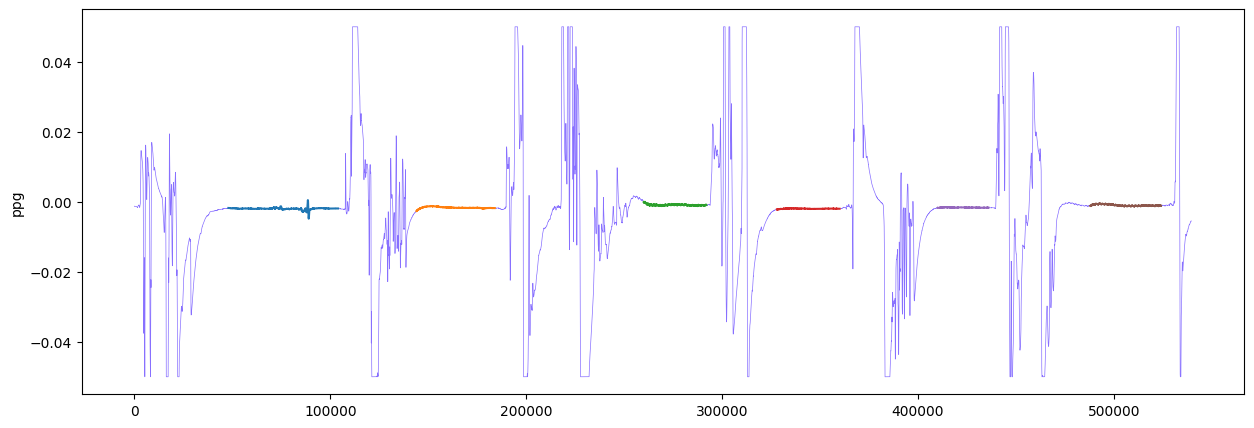

In [93]:
# Phil's hardware 
subset = None
# subset = (df_biopac['run'].isin(run)) # view data from a specific run
start = None
duration = 120
_ = make_figure(df_biopac,'ppg',subset=subset,fs=2000,start=start,duration=duration, legend=False)


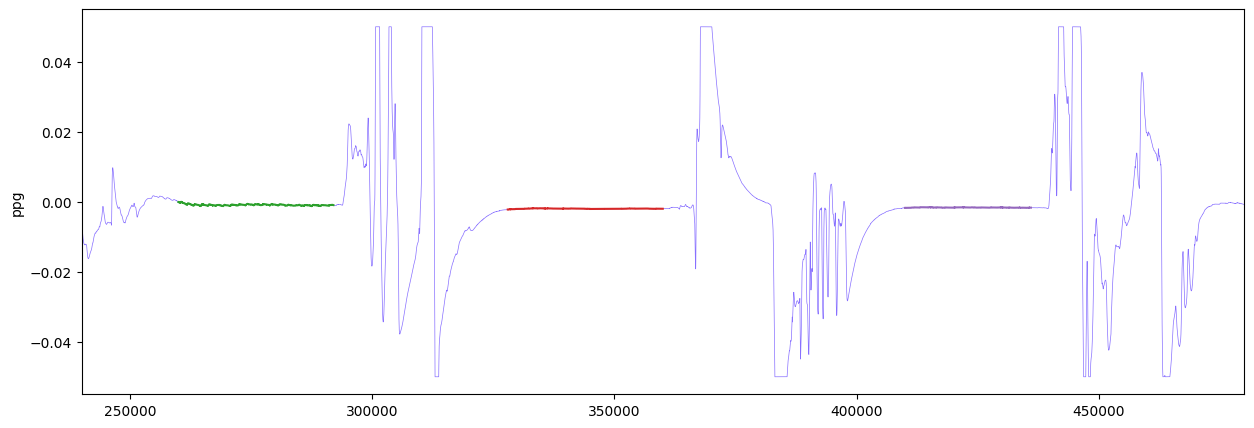

In [94]:
start = 120
duration = 120
_ = make_figure(df_biopac,'ppg',subset=subset,fs=2000,start=start,duration=duration, legend=False)

## Compare PPG waveforms across 2 devices

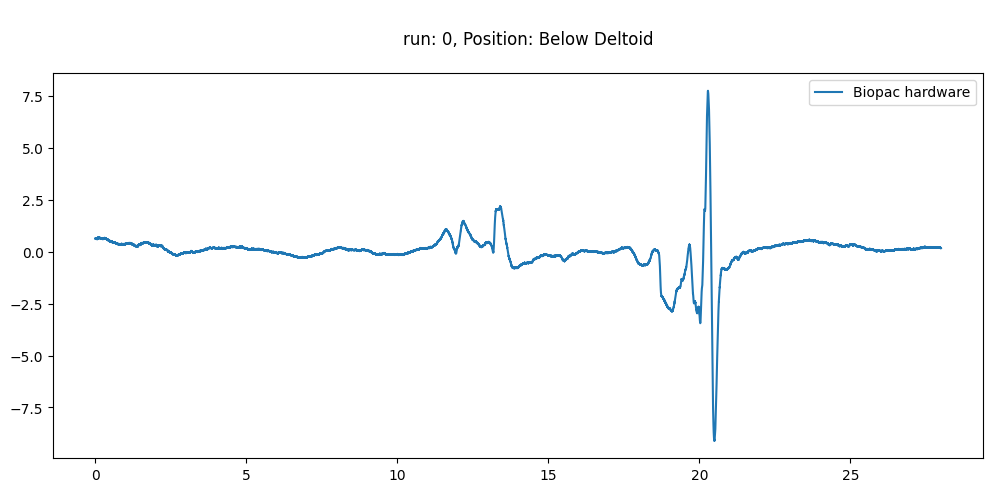

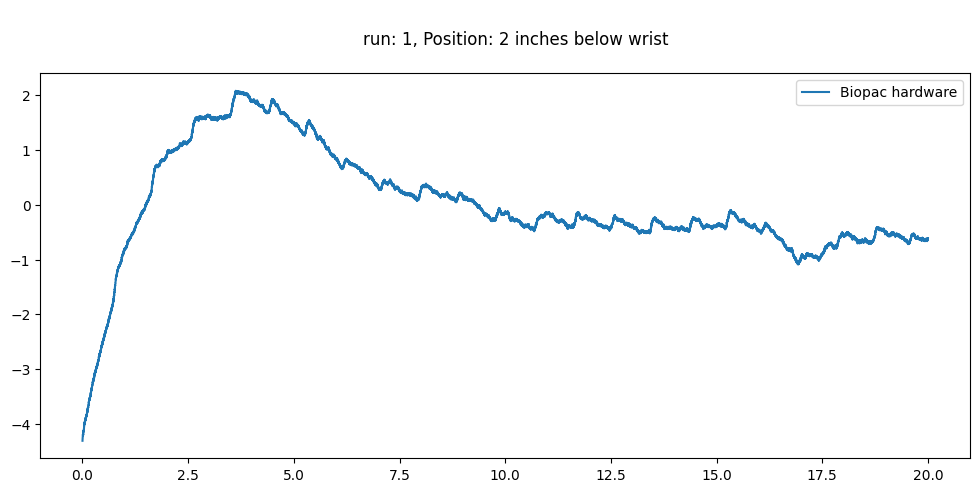

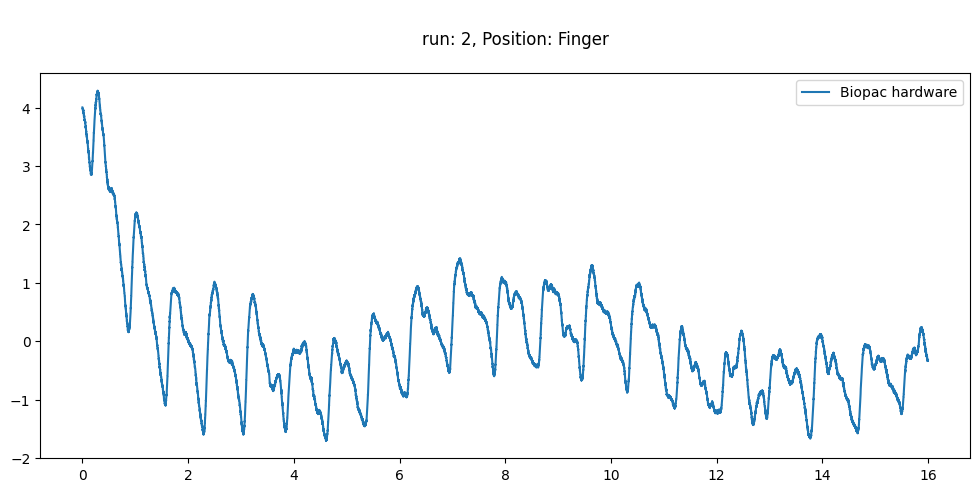

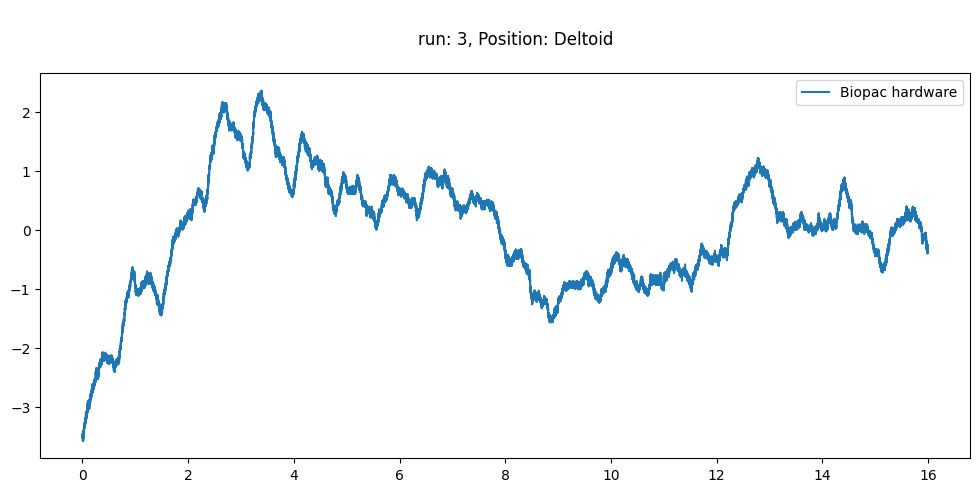

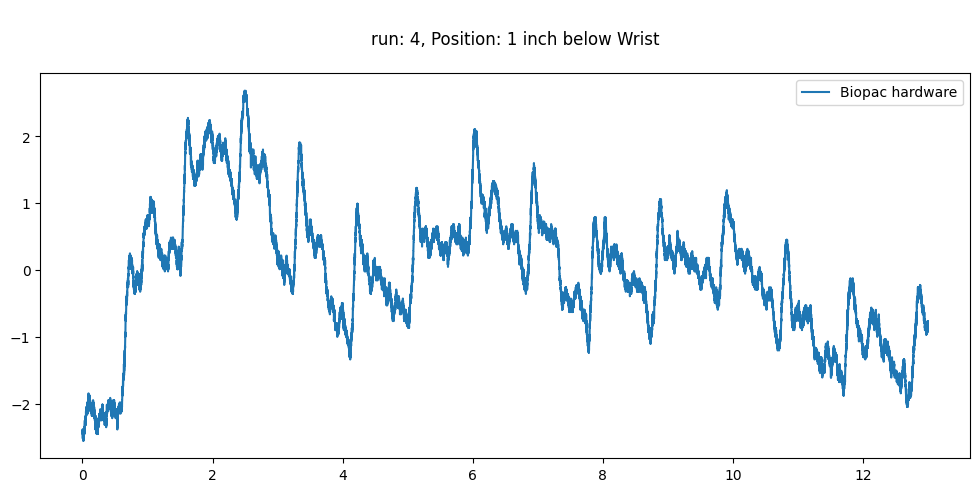

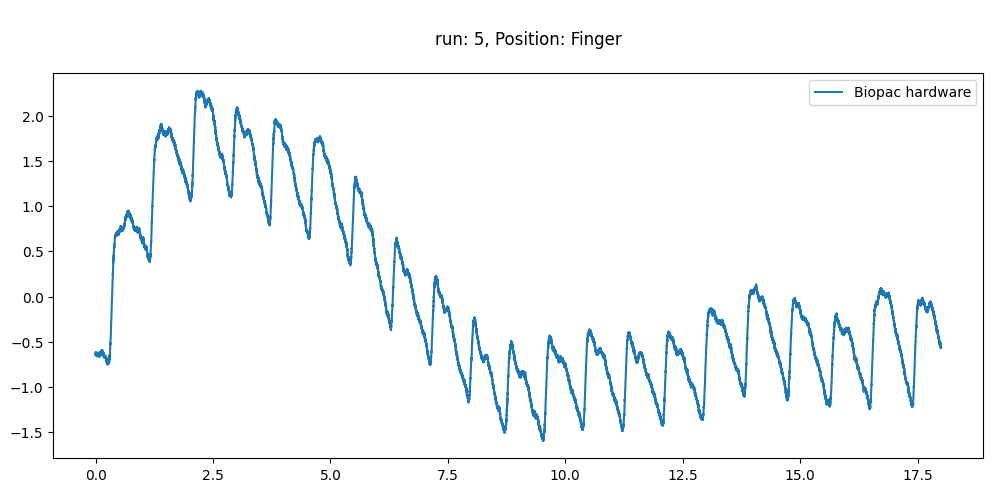

In [95]:
# manually adjust id between 015, 016, and 017, as well as P1 and P2
def standardize(data):
    return (data-np.mean(data))/np.std(data)

runs = timing_df['Run'].unique()
valid_run = []
run_label = []
rr_est1 = []
rr_est2 = []

for run in runs:
    biopac_subset = df_biopac['run'] == run

    # make axes and plot figures
    ppg_biopac = df_biopac[biopac_subset]['ppg']
    
    x_biopac = np.arange(0,len(ppg_biopac))/2000
    title = f"""
    run: {run}, Position: {timing_df[timing_df['Run']==run]['Note'].iloc[0]}
    """
    
    plt.figure(figsize=(12,5))
    plt.plot(x_biopac,standardize(ppg_biopac), label = 'Biopac hardware')
    plt.title(title)
    plt.legend()
    plt.show()
    
    # Also do RR estimation with algorithm
    labels = ['Biopac']
    ppgs = [ppg_biopac]
    fss = [2000,250]
    for ppg,fs,label in zip(ppgs,fss,labels):
        # ppg_lp = util.lowpass_butter(ppg,250,5/60)
        # ppg_hp = ppg-ppg_lp
        (
        rr_candidate_merged,
        all_rr_candidates,
        feature_quality,
        ) = estimate_rr_single_frame(
            ppg=ppg,
            fs_ppg=fs,
            hr_est=70,
            rr_max=70/1.75,
            min_resp_freq=4/60,
            rr_est=10,
            remove_riv_outliers=None,
            fs_riv=20,
            n_sig=3,
            show=False,
        )
            
        valid_run.append(run)
        run_label.append(label)
        rr_est1.append(rr_candidate_merged['kalman'])
        rr_est2.append(rr_candidate_merged['simple median'])
                
results_df = pd.DataFrame({
    "run":valid_run,
    "hardware":run_label,
    "kalman est":rr_est1,
    "simple median est": rr_est2,
})

In [39]:
results2 = results_df.pivot(index='run',columns='hardware',values=['kalman est','simple median est'])
results2

kalman est            simple median est          
hardware     Biopac  NH Custom            Biopac NH Custom
run                                                       
0         11.425781  16.406250         14.930000  16.40625
1         12.304688  11.425781         18.750000  13.48000
2         18.164062  21.093750         18.164062  14.94000
3         20.214844  15.820312         19.400000  18.16000
4         21.679688  18.164062         20.215000  18.16000
5         14.941406  11.425781         15.230000  12.89000
6         26.367188  27.246094         17.580000  22.99000
7         20.507812  14.941406         18.415000  19.33000
8         15.820312  19.921875         18.750000  16.41000
9         12.597656  14.355469         15.920000  18.75000

In [36]:
results2.to_csv(f'{exp_directory}/evaluation_results_accel_test_20230814.csv')

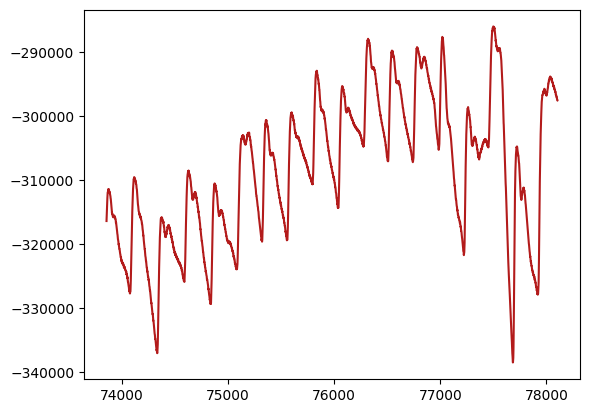

In [46]:
# Manually pull out figures for presentation
subset = (df['run']==6) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)
plt.plot(ppg_nh, color="#B31B1B")
# plt.ylim([-.85,-.6])

# Save data if desired
# nh_subset_ppg.to_csv('ppg_example.csv', index=False)

In [16]:
subset = (df['run']==5) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)

(
rr_candidate_merged,
all_rr_candidates,
feature_quality,
) = estimate_rr_single_frame(
    ppg=ppg_nh.values,
    fs_ppg=250,
    hr_est=70,
    rr_max=70/1.75,
    min_resp_freq=4/60,
    rr_est=20,
    remove_riv_outliers=None,
    fs_riv=10,
    n_sig=3,
    show=False,
)

rr_candidate_merged

{'PSD, closest to prev RR': 16.99,
 'PSD median': 15.53,
 'Counting, median # peaks': 11.9,
 'simple median': 15.53,
 'kalman': 15.52734375,
 'Counting, median pk delta': 15.13}

# Calculate SNR

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['smoothed_pressure'][5:],color="#8870ff", linewidth=0.5)
for run in df['run'].unique():
    plt.plot(df[df['run']==run]['smoothed_pressure'])
plt.title('raw pressure')
plt.xlim(110000,110000+50*fs)
plt.show()

In [48]:
# calculate SNR
target_signal = 'x1'

def power(arr):
    # power is equivalent to the mean-squared signal
    arr_centered = arr - np.mean(arr) #remove bias first
    squared_arr = np.square(arr_centered)
    return np.mean(squared_arr)

background_runs = df['run'].isin([0,5])
p_noise = power(df[background_runs][target_signal])

selectors = {
    'small motion':df['run'].isin([1,2,3,6,7,8]),
    'large motion':df['run'].isin([4,9]),
}

conditions = []
snrs = []
for condition, selector in selectors.items():
    runs = df[selector]['run'].unique()
    for run in runs:
        isolated_signal = df[selector & (df['run']==run)][target_signal]
        p_signal = power(isolated_signal)
        snr_db = 10*np.log10(p_signal/p_noise)
        
        conditions.append(condition)
        snrs.append(snr_db)

print(f'SNR (dB) for {target_signal}')
snr_df = pd.DataFrame({'condition':conditions,'snr (dB)':snrs})
snr_df.groupby('condition').agg(['mean', 'std'])

SNR (dB) for x1


snr (dB)          
                   mean       std
condition                        
large motion  22.392139  1.271046
small motion   8.220354  5.631667